# Overall Project Description

These models generate Colorado 14er hike recommendations for a given user, first based simply on a standard user-based collaborative filter engine with user similarities calculated via the Pearson coefficient determined from the (user,mountain) matrix of hike checklists. 

First a vanilla recommender is implemented.  Next, to address the "popularity bias" issue and de-emphasize the importance of a small number of highly popular peaks hiked by many users, the output recommendation lists will be rescaled inversely with peak popularity to boost the importance of the least popular peaks.

RMSE metric is included as a potential approach to evaluate recommendation lists.  However, some tradeoff between minimized RMSE and increased diversity of top recommendations is allowable in this context.  As a result, I have also defined an overall "entropy" metric to measure the variety of recommendations over users.

The same approach is repeated in a notebook for 13er hike recommendations.  There is a far wider scope of 13ers in Colorado, and more interesting utility to be gained from this latter recommendation engine.  The 14er recommender is constructed first to test model functionality with a pool of well-known peaks.




In [176]:
import pandas as pd
import numpy as np
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn
import json
#sns.reset_orig()
sns.set_style('white')
%matplotlib inline
pd.set_option('mode.chained_assignment',None)

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

### Import Checklist Data and User Data

Import checklist data that was previously scraped from a popular hiking website as part of this project and stored in a dataframe format.  My web scraping class and methods are included in github as "forum_scraper.py".  The user profile data was also scraped with the same script; this data is also imported to map user ID to user Name, and merge dataframes (left join).

The "NumClimbs" field will hold the effective "rating" given by a user to a peak.  Currently, the ratings $x_k$ are simply binary representations of whether a user successfully summited a peak: -1 (user did not hike the peak) or 1 (user did hike the peak).  While some users log multiple climbs, using the actual number of climbs exacerbates the long tail problem since many users return repeatedly to the popular peaks simply out of convenience and proximity to cities.  This recommendation system is instead designed to provide unique new suggestions.

In [182]:
fname_14erList = r'14erChecklistByUser_df_winterfix'
fname_13erList = r'13erChecklistByUser_df_winterfix'

df_14ers = pickle.load(open(fname_14erList,"rb"))
df_14ers = df_14ers[df_14ers['PeakName']!=""]
df_14ers = df_14ers.sort_values('PeakName')
df_14ers['NumClimbs'] = df_14ers['NumClimbs'].apply(lambda x: -1 if x==0 else 1)

fname_user = r'user_profile_data_FULL_winterfix'
user_df = pickle.load(open(fname_user,"rb"))
#user_df = user_df[['UserId','Username']]

df_14ers = pd.merge(df_14ers, user_df[['UserId','Username']], on='UserId', how='left')
df_14ers = df_14ers.drop_duplicates()
df_14ers.head()
#user_df.head()

UserId    PeakName  NumClimbs        Username
0  58801  BlancaPeak          1       Ozziejomi
1   4891  BlancaPeak          1      davidheese
2  11662  BlancaPeak          1  chrishoffbauer
3   4881  BlancaPeak          1      Cleatelite
4  15596  BlancaPeak          1        jwinters

In [96]:
user_df.head()

UserId         Username   Age MaxSkillLevel  \
0      3  BillMiddlebrook  52.0   Low Class 5   
1      4              CGB  40.0                 
2      5        AlisaWest   NaN                 
3      7    Robbie Crouse   NaN       Class 4   
4      8         roybal01   NaN                 

                                  ClimbingPreference Accomplishments  \
0  Scrambling and mostly unroped climbing where I...  Kids, marriage   
1                                                                      
2                                                                      
3                                                                      
4                                                                      

                                               Goals MyGearList  \
0  Ski 100 days (60/40 resort vs. bc) each year. ...              
1                                                                 
2                                                                 
3                                                                 
4                                                                 

                Location                  Occupation Num14ers Num13ers  \
0       Breckenridge, CO                     Retired       58      164   
1  Buena Vista, Colorado  Chaffee County SAR Officer       35      NaN   
2                                          Paralegal       57      NaN   
3                                                          14      NaN   
4                                                          12      NaN   

  NumPhotos NumTripReports NumClimbTimes       GearForSale  \
0      1854              7             0  No Gear For Sale   
1         0              0             0  No Gear For Sale   
2         0              0             0  No Gear For Sale   
3         0              0             0  No Gear For Sale   
4         0              0             0  No Gear For Sale   

             JoinDate      LastActiveDate NumPosts  
0 2004-07-25 22:34:00                 NaT     5788  
1 2004-07-26 10:30:00 2016-07-22 20:20:00       61  
2 2004-07-26 10:34:00 2010-08-05 11:04:00       51  
3 2004-07-26 10:42:00 2014-10-21 10:44:00       55  
4 2004-07-26 10:54:00 2008-03-22 16:02:00        6

In [183]:
numeric_cols = ['Age','Num14ers','Num13ers','NumPosts']
user_df[numeric_cols]=user_df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(value=np.nan)
nusers_tot = len(user_df)
nusers_age = len(user_df[user_df['Age']>0])
print('Fraction of users providing an age is '+ str(nusers_age/nusers_tot))


Fraction of users providing an age is 0.11770057288977404


##### Plot user distribution by age, for the 12% who gave their age.

In [14]:
user_df['Age'].iplot(kind='hist',xTitle='Age',yTitle='Count')

In [167]:
age_df = user_df[['Age','Num14ers']]
mask = age_df['Num14ers']>0
age_df['Has14erAge'] = age_df['Age']
##If they don't have 14ers logged,don't show their age
age_df['Has14erAge'][~mask]=np.nan
age_df[['Age','Has14erAge']].iplot(kind='hist',xTitle='Age',yTitle='Count')#age_df['Age'].iplot(kind='hist',xTitle='Age',yTitle='Count',hue='Has14ers')
#age_df.head()

##### Plot user distribution by join date and last active date (all users included)

In [101]:
jd = user_df.copy()
ja = user_df.copy()

jd = jd.groupby([jd['JoinDate'].dt.year.rename('year'), jd['JoinDate'].dt.month.rename('month')]).agg({'count'})#jd.groupby(jd.JoinDate.dt.to_period("M")).agg('count')
jd['UserId'].iplot(kind='bar',xTitle='Join Date',yTitle='Count',title='User Distribution of Join Dates')
ja = ja.groupby([ja['LastActiveDate'].dt.year.rename('year'), ja['LastActiveDate'].dt.month.rename('month')]).agg({'count'})#jd.groupby(jd.JoinDate.dt.to_period("M")).agg('count')
ja['UserId'].iplot(kind='bar',xTitle='Last Active Date',yTitle='Count',title = 'User Distribution of Last Active Dates')

##### Correlations in Normalized Numeric Columns

Some weak correlation between number of posts and number of 13ers and 14ers, as well as a correlation between number of 14ers and number of 13ers.  Age isn't really correlated with other factors.

In [174]:
from sklearn import preprocessing
x = user_df[numeric_cols].values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_users=pd.DataFrame(x_scaled, columns=numeric_cols)#scaled_users=pd.DataFrame(min_max_scaler.fit_transform((user_df[numeric_cols].T)))#, columns=numeric_cols, index=user_df.index)
#user_df.iplot(kind='scatter',mode='markers',x='Num14ers',y='NumPosts',filename='cufflinks/simple-scatter')
#(kind='bar',xTitle='Join Date',yTitle='Count',title='User Distribution of Join Dates')
#scaled_users.head(20)
scaled_users.corr().iplot(kind='heatmap',colorscale='Blues')

##### Next I drop some of the more obscure peaks from the 14ers checklist data.  Also plot to see counts distribution.

In [184]:
climb_counts = df_14ers.groupby('PeakName').agg('count').sort_values('NumClimbs')
climb_counts['UserId'].iplot(kind='bar',xTitle='Peak Name',yTitle='Logged Ascents')
dropnames = climb_counts[climb_counts['NumClimbs']<300].index.tolist()
df_14ers = df_14ers[df_14ers['PeakName'].apply(lambda x: x not in dropnames)]
#df_14ers[df_14ers['NewUserId']==4].head(40)

In [185]:
print(dropnames)

['SunlightSpire', 'SouthWilson', 'NortheastCrestone', 'SouthLittleBear', 'NorthSnowmass', 'SoutheastLongs', 'WestWilson']


##### Next I drop users with 2 or less climbs.  This is mainly to keep the dataset size manageable for my desktop.

In [195]:
#user_counts = df_14ers.groupby('UserId').agg('count').sort_values('NumClimbs')
#v = df_14ers['UserId'].apply(pd.to_numeric)
user_counts = df_14ers.UserId.value_counts()
#print(v)
user_counts.iplot(kind='hist',xTitle='Number Of Peaks',yTitle='Count')#climb_counts['UserId'].iplot(kind='bar',xTitle='Peak Name',yTitle='Logged Ascents')
gooduids = user_counts[user_counts >2].index.to_list()
df_14ers = df_14ers[df_14ers['UserId'].isin(gooduids)]


#### Create a dataframe that assigns an index to each peak


In [196]:
n_14er_users = df_14ers.UserId.nunique()
n_14ers = df_14ers.PeakName.nunique()
print(n_14er_users)
print(n_14ers)
## Create a dataframe that assigns an index to each peak
index_ind=pd.DataFrame(data={'PeakId':np.arange(len(df_14ers.PeakName.unique())),'PeakName':df_14ers.PeakName.sort_values().unique()})
index_ind.head(12)

15166
66


PeakId         PeakName
0        0       BlancaPeak
1        1      CapitolPeak
2        2       CastlePeak
3        3  ChallengerPoint
4        4    ConundrumPeak
5        5   CrestoneNeedle
6        6     CrestonePeak
7        7      CulebraPeak
8        8     EastCrestone
9        9      EastLaPlata
10      10     ElDientePeak
11      11  EllingwoodPoint

In [197]:
df_14ers = df_14ers.merge(index_ind)
df_14ers.head()

UserId    PeakName  NumClimbs        Username  PeakId
0  58801  BlancaPeak          1       Ozziejomi       0
1   4891  BlancaPeak          1      davidheese       0
2  11662  BlancaPeak          1  chrishoffbauer       0
3   4881  BlancaPeak          1      Cleatelite       0
4  15596  BlancaPeak          1        jwinters       0

#### Create an index for each user

We redo the original user ids since  they span the length of the full user database (>80k users), and we have only taken the subset of the users that have logged a 14er hike (~16 k)

In [198]:
index_id=pd.DataFrame(data={'NewUserId':np.arange(len(df_14ers.UserId.unique())),'UserId':df_14ers.UserId.unique()})
df_14ers = df_14ers.merge(index_id)
df_14ers.head()

UserId         PeakName  NumClimbs   Username  PeakId  NewUserId
0  58801       BlancaPeak          1  Ozziejomi       0          0
1  58801  EllingwoodPoint          1  Ozziejomi      11          0
2  58801        GraysPeak          1  Ozziejomi      12          0
3  58801      HandiesPeak          1  Ozziejomi      13          0
4  58801     HumboldtPeak          1  Ozziejomi      14          0

In [79]:
### Run if desired
pickle.dump(df_14ers,open(r'14ers_df_final_trunc2',"wb"))

In [109]:
### Split df into train/test.
### I didn't really end up using this for eval, since this is not a heavily parametrized model and there is thus not much risk of 
### "overtraining"
from sklearn.model_selection import train_test_split
random.seed(1000)
train_data14ers, test_data14ers = train_test_split(df_14ers, test_size=0.25)

## Build the similarity metric matrix between users based only on Pearson metric, and then create a peak prediction for each user 

In [81]:
train_data_userids = train_data14ers['NewUserId'].tolist()
test_data_userids = test_data14ers['NewUserId'].tolist()

In [199]:
print(n_14ers)
df_14ers.tail(25)

66


UserId         PeakName  NumClimbs         Username  PeakId  NewUserId
319665  61675      SanLuisPeak          1             tk58      52      15158
319666  61675       WindomPeak          1             tk58      65      15158
319667  51015     QuandaryPeak          1        Cat5Axual      50      15159
319668  51015     RedcloudPeak          1        Cat5Axual      51      15159
319669  51015  UncompahgrePeak          1        Cat5Axual      61      15159
319670  51015   WetterhornPeak          1        Cat5Axual      63      15159
319671  18660     QuandaryPeak          1         Dominion      50      15160
319672  18660      TorreysPeak          1         Dominion      60      15160
319673  18660  UncompahgrePeak          1         Dominion      61      15160
319674  38559     QuandaryPeak          1          maxpika      50      15161
319675  38559  UncompahgrePeak          1          maxpika      61      15161
319676  38559   WetterhornPeak          1          maxpika      63      15161
319677  27240     RedcloudPeak          1      Kanienkeha4      51      15162
319678  27240      SanLuisPeak          1      Kanienkeha4      52      15162
319679  27240     SunshinePeak          1      Kanienkeha4      58      15162
319680  79795     RedcloudPeak          1        rogowskid      51      15163
319681  79795     SunshinePeak          1        rogowskid      58      15163
319682  79795   WetterhornPeak          1        rogowskid      63      15163
319683  34053     RedcloudPeak          1         kayakred      51      15164
319684  34053  UncompahgrePeak          1         kayakred      61      15164
319685  34053   WetterhornPeak          1         kayakred      63      15164
319686  30293      SanLuisPeak          1  thatonekidd2112      52      15165
319687  30293     SunlightPeak          1  thatonekidd2112      57      15165
319688  30293  UncompahgrePeak          1  thatonekidd2112      61      15165
319689  30293   WetterhornPeak          1  thatonekidd2112      63      15165

In [200]:
full_data_matrix = -1*np.ones((n_14er_users, n_14ers))
for line in df_14ers.itertuples():
    full_data_matrix[line[6], line[5]] = line[3]
train_data_matrix = np.copy(full_data_matrix)
train_data_matrix[train_data_userids,:]=0
test_data_matrix = np.copy(full_data_matrix)
test_data_matrix[test_data_userids,:]=0


### Pearson Metric 

$s(u_i,u_j)=\frac{\sum_k (x_{i,k}-\bar{x_i})(x_{j,k}-\bar{x_j})}{\sqrt{\sum_k (x_{i,k}-\bar{x_i})^2 \sum_k (x_{j,k}-\bar{x_j})^2}}$

where $x_{n,k}$ is the rating that a user $(i,j)$ gives to a summit of peak $k$, and $\bar{x}_n$ is the average rating over all peaks given by user $n$.  

In [84]:
def pearson_correlation(full_data_matrix,frac=1.0):
    epsilon = 1e-5
    #train_data_matrix has dimensions of (nusers,n14ers)
    nusers = np.shape(full_data_matrix)[0]
    pcorr_matrix = np.zeros((nusers,nusers))
    user_means = np.mean(full_data_matrix,axis=1)*1/frac ##rescale if needed when inputting partially-zeroed matrices from train and test
    mean_subtract = full_data_matrix - np.reshape(user_means,(nusers,1))
    denom_sum_sq = (np.sum((mean_subtract)**2,axis=1))**0.5 + epsilon
    for i in range(nusers):
        for j in range(nusers):
            pcorr_matrix[i,j] = np.dot(mean_subtract[i,:],mean_subtract[j,:])/(denom_sum_sq[i]*denom_sum_sq[j])
    return pcorr_matrix

In [32]:
def cosine_correlation(full_data_matrix,frac=1):
    epsilon = 1e-5
    #train_data_matrix has dimensions of (nusers,n14ers)
    nusers = np.shape(full_data_matrix)[0]
    pcorr_matrix = np.zeros((nusers,nusers))
    user_means = np.mean(full_data_matrix,axis=1)*1/frac 
    denom_sum_sq = (np.sum((full_data_matrix)**2,axis=1))**0.5 + epsilon
    for i in range(nusers):
        for j in range(nusers):
            pcorr_matrix[i,j] = np.dot(mean_subtract[i,:],mean_subtract[j,:])/(denom_sum_sq[i]*denom_sum_sq[j])
    return pcorr_matrix

In [85]:
### WARNING: this will take a bit of time (~10 mins).  Pre-Load data if possible
user_similarity_full = pearson_correlation(full_data_matrix,1.0)
#pickle.dump(user_similarity_full_winterfix,open(r'user_similarities_14er_pearson_full',"wb"))

In [86]:
### RUN THIS IF NEEDED
pickle.dump(user_similarity_full,open(r'user_similarities_14er_pearson_gt2_winterfix',"wb"))

In [33]:
### RUN THIS IF FILE EXISTS
user_similarity_full=pickle.load(open(r'user_similarities_14er_pearson_full_winterfix',"rb"))

In [201]:
print(user_similarity_full[5001,-4000:-3900])

[ 3.97571602e-01  3.55513079e-01  2.73860448e-01  2.42064483e-01
  4.86538209e-01  4.94085371e-01  2.96173419e-01  2.42064483e-01
  2.27183773e-01  1.79250919e-01  4.36562763e-01  3.32180744e-01
  2.21358753e-01  3.91860812e-01  2.36362856e-01  4.54543953e-01
  4.87947789e-01  3.74099655e-01  1.65747863e-01  2.42534868e-01
  2.42064483e-01  2.10817826e-01  1.27272307e-01  4.54543953e-01
  2.27183773e-01  1.26490716e-01  2.82841640e-01  2.07612965e-01
  3.32894564e-01  4.56748524e-01  3.97571602e-01  4.80077931e-01
  1.77704051e-01  3.05504138e-01  3.64645298e-01  4.80077931e-01
  1.79250919e-01  2.35906424e-01  2.01235256e-01  1.79250919e-01
  2.73860448e-01  1.05408913e-01  2.27183773e-01  3.24371333e-01
  3.91860812e-01  2.65196580e-01  2.64574240e-01  3.87374633e-01
  3.77963200e-02  3.77963200e-02  4.86538209e-01  2.65196580e-01
  5.27044565e-01  2.96173419e-01  2.64574240e-01  3.41313833e-01
  4.24262460e-01  2.65196580e-01  8.45151778e-02  2.82841640e-01
  4.11094827e-01  1.79250

##### Spot checks to make sure that the 14er lists of user pairs rated most similar are actually close

In [110]:
user_similarity=user_similarity_full
sim_to_10000=user_similarity[10000,:].argsort() 
sim_to_5600=user_similarity[5600,:].argsort()
#print(user_similarity[10000,sim_to_5600[-2]])
#print(user_similarity[5000,sim_to_10000])
print('Check User 10000')
print(df_14ers[df_14ers['NewUserId']==sim_to_10000[-2]])
print('\n')
print(df_14ers[df_14ers['NewUserId']==10000])
print('\n\n')
print('Check User 5600')
print(df_14ers[df_14ers['NewUserId']==sim_to_5600[-2]])
print('\n')
print(df_14ers[df_14ers['NewUserId']==5600])

Check User 10000
       UserId         PeakName  NumClimbs       Username  PeakId  NewUserId
249354  49543        GraysPeak          1  scottdunsmuir      12       8157
249355  49543        MtBelford          1  scottdunsmuir      24       8157
249356  49543          MtBross          1  scottdunsmuir      26       8157
249357  49543        MtCameron          1  scottdunsmuir      27       8157
249358  49543       MtDemocrat          1  scottdunsmuir      29       8157
249359  49543         MtElbert          1  scottdunsmuir      30       8157
249360  49543        MtMassive          1  scottdunsmuir      35       8157
249361  49543         MtOxford          1  scottdunsmuir      36       8157
249362  49543        MtShavano          1  scottdunsmuir      38       8157
249363  49543        MtSherman          1  scottdunsmuir      39       8157
249364  49543     QuandaryPeak          1  scottdunsmuir      50       8157
249365  49543   TabeguachePeak          1  scottdunsmuir      59       

### Compute predictions

The recommendation for peak "k" for a given user $n$ is then calculated from the user similarities according to the intuition that probable likelihood of hiking a given peak is added to the average likelihood of hiking any peak for user "n" ($\bar{x}_k$) as a normalized, similarity-weighted sum over the mean-subtracted likelihood for all users "m":

$\hat{x}_{k,n} = \bar{x}_k + \frac{\sum_{u_m}s(u_n, u_m)(x_{k,m} - \bar{x}_m)}{\left| \sum_{u_m}{s(u_n,u_m)} \right|}$



In [88]:
def predict(ratings, similarity):
    epsilon = 1e-5
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / (np.array([np.abs(similarity).sum(axis=1)])+epsilon).T
    return pred

In [89]:
user_prediction_full = predict(full_data_matrix, user_similarity_full)

In [90]:
### The prediction matrix along with the user info dataframe will be used to make the Flask API
pickle.dump(user_prediction_full,open(r'user_prediction_gt2_winterfix',"wb"))

### Perform some spot-checks of the recommendations

Encouraging to see that the first user has only hiked in the San Juans, and is recommended other mountains in the San Juans.

In [203]:
print(len(user_prediction_full))

15166


In [95]:
np.shape(user_prediction_full)
### For now I just want to explicitly exclude the common peaks
common_peaks = ['GraysPeak', 'MtBierstadt', 'QuandaryPeak', 'TorreysPeak', 'MtDemocrat', 'MtElbert', 'MtBross', 'MtCameron', 'MtEvans', 'MtSherman', 'PikesPeak']
n=12
user_prediction=user_prediction_full.astype('float')

args=((-user_prediction[15165,:]).argsort())
hiked_list_15166 = (df_14ers[df_14ers['NewUserId']==15165])['PeakName'].tolist()
print('User 15166 Hiked:')
print(hiked_list_15166)
rec_list_15166 = index_ind['PeakName'][args].tolist()
new_rec_list_15166 = [elem for elem in rec_list_15166 if elem not in hiked_list_15166 and elem not in common_peaks]
print('\n\n')
print('Recommendation for User 15166:')
print(new_rec_list_15166[0:n])
args=((-user_prediction[5600,:]).argsort())
hiked_list_5600 = (df_14ers[df_14ers['NewUserId']==5600])['PeakName'].tolist()
print('\n\n')
print('User 5600 Hiked:')
print(hiked_list_5600)
rec_list_5600 = index_ind['PeakName'][args].tolist()
new_rec_list_5600 = [elem for elem in rec_list_5600 if elem not in hiked_list_5600 and elem not in common_peaks]
print('\n\n')
print('Recommendation for User 5600:')
print(new_rec_list_5600[0:n])

hiked_list_8600 = (df_14ers[df_14ers['NewUserId']==8600])['PeakName'].tolist()
print('\n\n')
print('User 8600 Hiked:')
print(hiked_list_8600)
rec_list_8600 = index_ind['PeakName'][args].tolist()
new_rec_list_8600 = [elem for elem in rec_list_8600 if elem not in hiked_list_8600 and elem not in common_peaks]
print('\n\n')
print('Recommendation for User 8600:')
print(new_rec_list_8600[0:n])

User 15166 Hiked:
['SanLuisPeak', 'SunlightPeak', 'UncompahgrePeak', 'WetterhornPeak']



Recommendation for User 15166:
['WindomPeak', 'MtEolus', 'HandiesPeak', 'RedcloudPeak', 'SunshinePeak', 'NorthEolus', 'WilsonPeak', 'MtSneffels', 'MtWilson', 'ElDientePeak', 'CulebraPeak', 'SnowmassMountain']



User 5600 Hiked:
['CastlePeak', 'ConundrumPeak', 'GraysPeak', 'HandiesPeak', 'LongsPeak', 'MissouriMountain', 'MtBelford', 'MtBierstadt', 'MtElbert', 'MtEvans', 'MtOxford', 'MtoftheHolyCross', 'PikesPeak', 'QuandaryPeak', 'SunlightPeak', 'TorreysPeak', 'UncompahgrePeak', 'WestEvans']



Recommendation for User 5600:
['MtMassive', 'HuronPeak', 'LaPlataPeak', 'MtYale', 'MtShavano', 'MtPrinceton', 'MtHarvard', 'TabeguachePeak', 'MtAntero', 'MtColumbia', 'RedcloudPeak', 'HumboldtPeak']



User 8600 Hiked:
['GraysPeak', 'MtBelford', 'MtBierstadt', 'MtOxford', 'MtShavano', 'MtYale', 'QuandaryPeak', 'TabeguachePeak', 'TorreysPeak']



Recommendation for User 8600:
['LongsPeak', 'MtMassive', 'Huro

### Re-scale recommendations so that more popular peaks are penalized without explicitly removing these peaks as above.  Try both linear and exponential scaling

In [231]:
np.max(user_prediction_full)
print(np.min(user_prediction_full))

-1.7739741381978336


In [219]:
np.shape(user_prediction_full)
### For now I just want to explicitly exclude the common peaks
common_peaks = ['GraysPeak', 'MtBierstadt', 'QuandaryPeak', 'TorreysPeak', 'MtDemocrat', 'MtElbert', 'MtBross', 'MtCameron', 'MtEvans', 'MtSherman', 'PikesPeak']
n=12
user_prediction=user_prediction_full.astype('float')

args=((-user_prediction[15165,:]).argsort())
hiked_list_15166 = (df_14ers[df_14ers['NewUserId']==15165])['PeakName'].tolist()
print('User 15166 Hiked:')
print(hiked_list_15166)
rec_list_15166 = index_ind['PeakName'][args].tolist()
new_rec_list_15166 = [elem for elem in rec_list_15166 if elem not in hiked_list_15166 and elem not in common_peaks]
print('\n\n')
print('Recommendation for User 15166:')
print(new_rec_list_15166[0:n])
args=((-user_prediction[5600,:]).argsort())
hiked_list_5600 = (df_14ers[df_14ers['NewUserId']==5600])['PeakName'].tolist()
print('\n\n')
print('User 5600 Hiked:')
print(hiked_list_5600)
rec_list_5600 = index_ind['PeakName'][args].tolist()
new_rec_list_5600 = [elem for elem in rec_list_5600 if elem not in hiked_list_5600 and elem not in common_peaks]
print('\n\n')
print('Recommendation for User 5600:')
print(new_rec_list_5600[0:n])

hiked_list_8600 = (df_14ers[df_14ers['NewUserId']==8600])['PeakName'].tolist()
print('\n\n')
print('User 8600 Hiked:')
print(hiked_list_8600)
rec_list_8600 = index_ind['PeakName'][args].tolist()
new_rec_list_8600 = [elem for elem in rec_list_8600 if elem not in hiked_list_8600 and elem not in common_peaks]
print('\n\n')
print('Recommendation for User 8600:')
print(new_rec_list_8600[0:n])

User 15166 Hiked:
['SanLuisPeak', 'SunlightPeak', 'UncompahgrePeak', 'WetterhornPeak']



Recommendation for User 15166:
['WindomPeak', 'MtEolus', 'HandiesPeak', 'RedcloudPeak', 'SunshinePeak', 'NorthEolus', 'WilsonPeak', 'MtSneffels', 'MtWilson', 'ElDientePeak', 'CulebraPeak', 'SnowmassMountain']



User 5600 Hiked:
['CastlePeak', 'ConundrumPeak', 'GraysPeak', 'HandiesPeak', 'LongsPeak', 'MissouriMountain', 'MtBelford', 'MtBierstadt', 'MtElbert', 'MtEvans', 'MtOxford', 'MtoftheHolyCross', 'PikesPeak', 'QuandaryPeak', 'SunlightPeak', 'TorreysPeak', 'UncompahgrePeak', 'WestEvans']



Recommendation for User 5600:
['MtMassive', 'HuronPeak', 'LaPlataPeak', 'MtYale', 'MtShavano', 'MtPrinceton', 'MtHarvard', 'TabeguachePeak', 'MtAntero', 'MtColumbia', 'RedcloudPeak', 'HumboldtPeak']



User 8600 Hiked:
['GraysPeak', 'MtBelford', 'MtBierstadt', 'MtOxford', 'MtShavano', 'MtYale', 'QuandaryPeak', 'TabeguachePeak', 'TorreysPeak']



Recommendation for User 8600:
['LongsPeak', 'MtMassive', 'Huro

In [237]:
peak_freqs = df_14ers.PeakId.value_counts()
asort = np.array((peak_freqs.index).to_list()).argsort()
climbs_tot = sum(peak_freqs.to_list())
peak_freqs = np.array(peak_freqs.to_list())/climbs_tot
peak_freqs=(peak_freqs[asort])/np.max(peak_freqs) #now ordered by peakId and scaled so that most climbed = 1 
#print(peak_freqs)

### Want to make sure and keep all values positive when performing the scales.  Add a constant offset to make sure.  Doesn't change the ordering of the results to add an offset.
user_prediction_linrescale = (user_prediction_full-np.min(user_prediction_full))*(1-peak_freqs)
user_prediction_exprescale = (user_prediction_full-np.min(user_prediction_full))*(np.exp(-0.75*peak_freqs))

### New spot check comparing recommendations with no scaling (and no manual removal of popular peaks), linearly scaled peak popularity penalty, and exponential decay peak popularity penalty

In [235]:
### For now I just want to explicitly exclude the common peaks

def pred_list(user_prediction_row,npeaks,index_ind,hiked_list):
    args=((-user_prediction_row.astype('float')).argsort())
    rec_list = index_ind['PeakName'][args].tolist()
    rec_list = [elem for elem in rec_list if elem not in hiked_list]
    return rec_list[0:npeaks]

In [236]:
hiked_list_15166 = (df_14ers[df_14ers['NewUserId']==15165])['PeakName'].tolist()
print('User 15166 Hiked:')
print(hiked_list_15166)
print('\n\n')
noscale_rec_15166 = pred_list((user_prediction[15165,:]-np.min(user_prediction_full)),12,index_ind,hiked_list_15166)
print('User 15166 Rec List, No Scaling:')
print(noscale_rec_15166)
print('\n\n')

linscale_rec_15166 = pred_list(user_prediction_linrescale[15165,:],12,index_ind,hiked_list_15166)
print('User 15166 Rec List, Linear Peak Popularity Penalty:')
print(linscale_rec_15166)
print('\n\n')

expscale_rec_15166 = pred_list(user_prediction_exprescale[15165,:],12,index_ind,hiked_list_15166)
print('User 15166 Rec List, Exponential Peak Popularity Penalty:')
print(expscale_rec_15166)


User 15166 Hiked:
['SanLuisPeak', 'SunlightPeak', 'UncompahgrePeak', 'WetterhornPeak']



User 15166 Rec List, No Scaling:
['WindomPeak', 'MtEolus', 'HandiesPeak', 'RedcloudPeak', 'SunshinePeak', 'NorthEolus', 'WilsonPeak', 'MtSneffels', 'MtWilson', 'ElDientePeak', 'CulebraPeak', 'SnowmassMountain']



User 15166 Rec List, Linear Peak Popularity Penalty:
['NorthEolus', 'MtEolus', 'EastCrestone', 'WindomPeak', 'NorthwestLindsey', 'ElDientePeak', 'EastLaPlata', 'MtWilson', 'WilsonPeak', 'CulebraPeak', 'MassiveGreen', 'NorthMassive']



User 15166 Rec List, Exponential Peak Popularity Penalty:
['WindomPeak', 'MtEolus', 'NorthEolus', 'WilsonPeak', 'ElDientePeak', 'MtWilson', 'CulebraPeak', 'EastCrestone', 'NorthwestLindsey', 'EastLaPlata', 'SnowmassMountain', 'LittleBearPeak']



User 15166 Rec List, No Scaling:
['MtBelford', 'MtMassive', 'HuronPeak', 'LaPlataPeak', 'MtYale', 'MtOxford', 'MtPrinceton', 'MtShavano', 'MissouriMountain', 'MtoftheHolyCross', 'MtHarvard', 'TabeguachePeak']





## Testing Solution -- Potential Metrics

#### RMSE

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [ ]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))


#### Recommendation Entropy

I am also defining a metric I'll call the "recommendation entropy", equal to the standard information entropy definition of

-$\sum_k p_k \text{log}(p_k)$, where here $p_k$ is a fractional value equal to the number of times a given peak $k$ was recommended as a top-10 peak over the pool of users, divided by the total number of users.

In [275]:
def calc_rec_entropy(user_prediction):
    nusers = np.shape(user_prediction)[0]
    npeaks = np.shape(user_prediction)[1]
    probs = np.zeros((npeaks,1))
    for n in range(npeaks):
        args=((-user_prediction).argsort())
        user_pred_top10 = args[:,0:10]
        probs[n] = np.sum(user_pred_top10 == n)
    probs = probs/float(nusers)
    return -1/10.0*np.dot((probs.flatten()),np.log((probs.flatten())))
        



In [246]:
ent_10=calc_rec_entropy(user_prediction)
print(ent_10)

ent_10=calc_rec_entropy(user_prediction_exprescale+1e-5)
print(ent_10)

0.28806847083689674
1.1588062703092075


### Recommendation Entropy, Part 2

Finally, out of curiousity I would like to see how recommendation entropy can be optimized as a function of exponential popularity penalty scale factor (intuition: too small doesn't help reshuffle the recs, too large just makes the UNpopular peaks always come up first).  Code and plot for this is below.


In [257]:
def calc_rec_entropy_expsc(user_prediction,sc,peak_freqs):
    user_prediction_exprescale = (user_prediction-np.min(user_prediction))*(np.exp(-sc*peak_freqs))
    nusers = np.shape(user_prediction_exprescale)[0]
    npeaks = np.shape(user_prediction_exprescale)[1]
    probs = np.zeros((npeaks,1))
    for n in range(npeaks):
        args=((-user_prediction_exprescale).argsort())
        user_pred_top10 = args[:,0:10]
        probs[n] = np.sum(user_pred_top10 == n)
    probs = probs/float(nusers)
    return -1/10.0*np.dot((probs.flatten()),np.log((probs.flatten()+1e-5)))

In [258]:
scales = np.linspace(0,5,50)
ent = np.zeros((50,1))
for n in range(len(scales)):
    ent[n] = calc_rec_entropy_expsc(user_prediction,scales[n],peak_freqs)

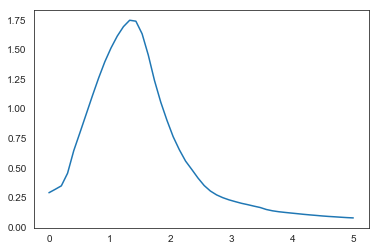

In [274]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(scales,ent)

'Popularity Penalty Exponential Factor'

# Note on visualization and distribution

One of the best ways to let others visualize and make use of this type of analysis is to give them a way to access the results without needing all the Python libraries installed on their local machine.  For this reason, my main focus from a "visualization" perspective was to learn how to package the results into a REST API using Flask in Python, and then make this API accessible via a web server.

I deployed my API on a web server using the Heroku service, and am working on developing a front-end using react.js.  (Right now, I have an extremely simple react front-end running).  HTTP post requests are made to the Flask app from the front-end.  Currently the API's recommendation output is just shown as the raw JSON.  

I have just completed debugging in figuring out how to successfully send the response back to the front-end using Axios so that it can be integrated into the javascript, and I look forward to having a prettier version of this full app up and running quite soon!


In [256]:
np.log(0+1e-5)

-11.512925464970229